<h1 style='text-align:center; background-color:darkgreen; color:white; padding:10px'>IMDB DataSet from Kaggle</h1>

In [148]:
#IMPORT LIBRARIES
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
#Getting the dataset's Path in the "files" directory
for root, dirs, files in os.walk('files'):
    for file in files:
        print(os.path.join(root, file))

files\IMDb_All_Genres_etf_clean1.csv


In [206]:
#Reading data to a Pandas DataFrame
#na_values = Strings that should be considered as null
df = pd.read_csv('files\IMDb_All_Genres_etf_clean1.csv', na_values=['', '-'])

<h2 style='text-align:center; background-color:darkgreen; color:white; padding:10px'>Preliminary Data analyzes</h2>

In [84]:
df.head()

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre
0,Kantara,2022,Rishab Shetty,"Rishab Shetty, Sapthami Gowda, Kishore Kumar G...",9.3,148,UA,NaN,Action,"Adventure, Drama"
1,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0,152,UA,$534.86M,Action,"Crime, Drama"
2,The Lord of the Rings: The Return of the King,2003,Peter Jackson,"Elijah Wood, Viggo Mortensen, Ian McKellen, Or...",9.0,201,U,$377.85M,Action,"Adventure, Drama"
3,Inception,2010,Christopher Nolan,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellio...",8.8,148,UA,$292.58M,Action,"Adventure, Sci-Fi"
4,The Lord of the Rings: The Two Towers,2002,Peter Jackson,"Elijah Wood, Ian McKellen, Viggo Mortensen, Or...",8.8,179,UA,$342.55M,Action,"Adventure, Drama"


In [75]:
#shape = rows x columns
df.shape

(5562, 10)

In [86]:
#Information
df.info()

#Notice: 
    #that there is no null value anyway
    #data types for numeric types are ok

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5562 entries, 0 to 5561
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Movie_Title    5562 non-null   object 
 1   Year           5562 non-null   int64  
 2   Director       5562 non-null   object 
 3   Actors         5562 non-null   object 
 4   Rating         5562 non-null   float64
 5   Runtime(Mins)  5562 non-null   int64  
 6   Censor         5562 non-null   object 
 7   Total_Gross    5562 non-null   object 
 8   main_genre     5562 non-null   object 
 9   side_genre     5562 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 434.7+ KB


In [45]:
#Correlation between columns
df.corr(numeric_only=True)

,Year,Rating,Runtime(Mins)
Year,1.000000,-0.291711,0.022971
Rating,-0.291711,1.000000,0.323256
Runtime(Mins),0.022971,0.323256,1.000000


In [53]:
#Statistical Information
df.describe()

#Notice that although There is no corelation betweem columns, there ir a correlation between number of movies and their year. Despite the oldest movie is from 1920, just 25% of them are from before 1997. This will be ilustrated at the chart down below.

,Year,Rating,Runtime(Mins)
count,5562.000000,5562.000000,5562.000000
mean,2002.792521,6.755861,112.226717
std,16.143990,0.937133,21.612655
min,1920.000000,1.000000,45.000000
25%,1997.000000,6.200000,97.000000
50%,2007.000000,6.800000,108.000000
75%,2014.000000,7.400000,123.000000
max,2022.000000,9.300000,321.000000


<h2 style='text-align:center; background-color:darkgreen; color:white; padding:10px'>Visualizations</h2>

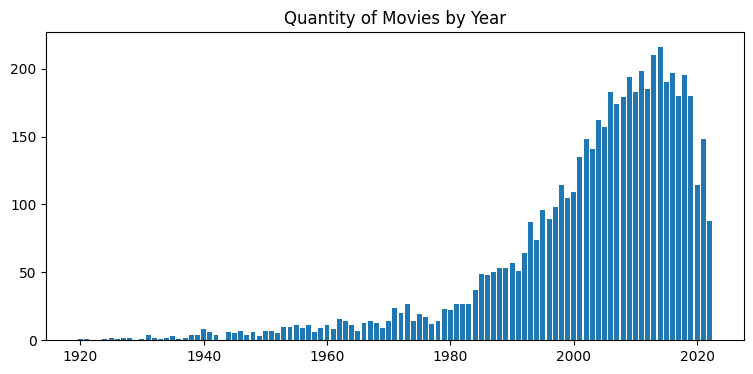

In [36]:
#Chart to explain the point at the last commentary
plt.figure(num=0, figsize=(9,4))
plt.bar(df['Year'].value_counts().index, df['Year'].value_counts().values)
plt.title('Quantity of Movies by Year')
plt.show()

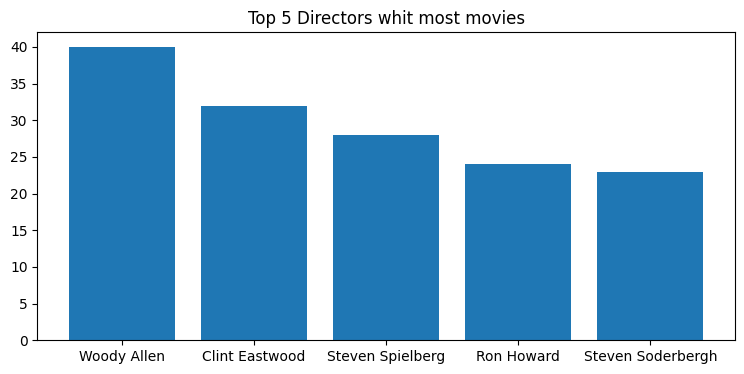

In [41]:
#Top 5 directors in quantity of movies
plt.figure(figsize=(9,4))
plt.bar(df['Director'].value_counts()[:5].index, df['Director'].value_counts()[:5].values)
plt.title('Top 5 Directors whit most movies')
plt.show()

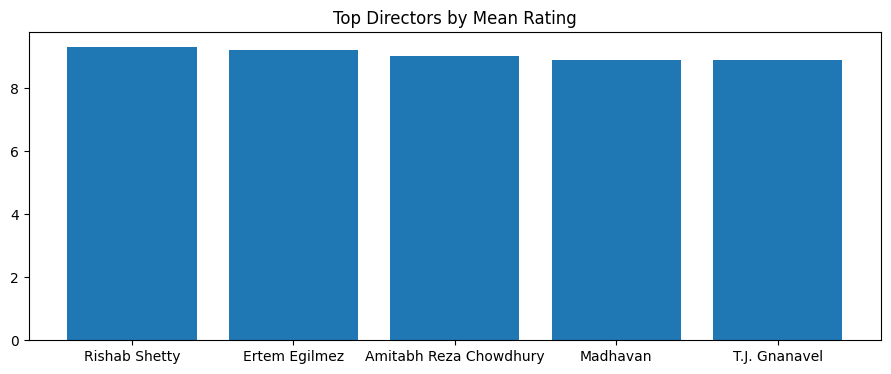

In [58]:
#Top 5 directors in mean rating
top_directors_rt = df.groupby('Director')['Rating'].mean().sort_values(ascending=False)[:5]
plt.figure(figsize=(11,4))
plt.bar(top_directors_rt.index, top_directors_rt.values)
plt.title('Top Directors by Mean Rating')
plt.show()

In [6]:
#TOP Movies by Rating
df.sort_values('Rating', ascending=False)[['Movie_Title', 'Rating']][:5]

,Movie_Title,Rating
0,Kantara,9.3
3448,The Shawshank Redemption,9.3
3449,Hababam Sinifi,9.2
2253,The Godfather,9.2
2,The Lord of the Rings: The Return of the King,9.0


In [77]:
#TOP Actors with most appearances

actors = df['Actors']
pd.Series(', '.join(list(actors)).split(', ')).value_counts()[:5]

Robert De Niro       61
Tom Hanks            49
Samuel L. Jackson    48
Nicolas Cage         47
Johnny Depp          42
dtype: int64

<h2 style='text-align:center; background-color:darkgreen; color:white; padding:10px; margin:0px'>Total Gross</h2>
<h3 style='text-align:center; background-color:darkgreen; color:white; padding:10px; margin:0px'>Feature Engineering</h3>

<p>
    <ol>
        <li>First, to order by the total gross, whe have to change the type into a numeric type. As whe can see, there is a dollar sign in the left and a 'M' at the end that probably means Million.</li> 
        <li>Then, lets check if all the rows match this pattern in the step 1. </li>
        <li>Then, lets drop the non-pattern values. At least, lets order by the float conversion of the values.</li>
    </ol>
</p>

In [198]:
# Step 1
#We already know that there is no null value.
#Now we know that there is no other possibility: either it are in the patter '$123.45M' or it is 'Gross unknow'

df.loc[~df['Total_Gross'].str.contains(r'^\$[0-9.]+M$')]['Total_Gross'].value_counts()

Gross Unkown    861
Name: Total_Gross, dtype: int64

In [223]:
#Step 2
#Lets remove the 861 rowns whit the 'Gross Unknow'

gross = df.drop(df.loc[df['Total_Gross'] == 'Gross Unkown'].index)

In [257]:
# Finaly, lets Sort by the float values

gross.sort_values('Total_Gross', ascending=False, key=lambda x: x.str.extract(r'([0-9.]+)', expand=False).astype(float)).head(5)

,Movie_Title,Year,Director,Actors,Rating,Runtime(Mins),Censor,Total_Gross,main_genre,side_genre
130,Star Wars: Episode VII - The Force Awakens,2015,J.J. Abrams,"Daisy Ridley, John Boyega, Oscar Isaac, Domhna...",7.8,138,U,$936.66M,Action,"Adventure, Sci-Fi"
19,Avengers: Endgame,2019,"Directors:Anthony Russo, Joe Russo","Robert Downey Jr., Chris Evans, Mark Ruffalo, ...",8.4,181,UA,$858.37M,Action,"Adventure, Drama"
31,Spider-Man: No Way Home,2021,Jon Watts,"Tom Holland, Zendaya, Benedict Cumberbatch, Ja...",8.3,148,UA,$804.75M,Action,"Adventure, Fantasy"
142,Avatar,2009,James Cameron,"Sam Worthington, Zoe Saldana, Sigourney Weaver...",7.8,162,UA,$760.51M,Action,"Adventure, Fantasy"
317,Black Panther,2018,Ryan Coogler,"Chadwick Boseman, Michael B. Jordan, Lupita Ny...",7.3,134,UA,$700.06M,Action,"Adventure, Sci-Fi"
